## Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

2024-11-13 07:57:39.646335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 07:57:39.884747: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 07:57:39.956572: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 07:57:47.405144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [4]:
print('Train Images Shape:           ', x_train.shape)
print('Train Labels Shape:           ', y_train.shape)

print('\nValidation Images Shape:      ', x_valid.shape)
print('Validation Labels Shape:      ', y_valid.shape)

print('\nTest Images Shape:            ', x_test.shape)
print('Test Labels Shape:            ', y_test.shape)

Train Images Shape:            (40000, 32, 32, 3)
Train Labels Shape:            (40000, 1)

Validation Images Shape:       (10000, 32, 32, 3)
Validation Labels Shape:       (10000, 1)

Test Images Shape:             (10000, 32, 32, 3)
Test Labels Shape:             (10000, 1)


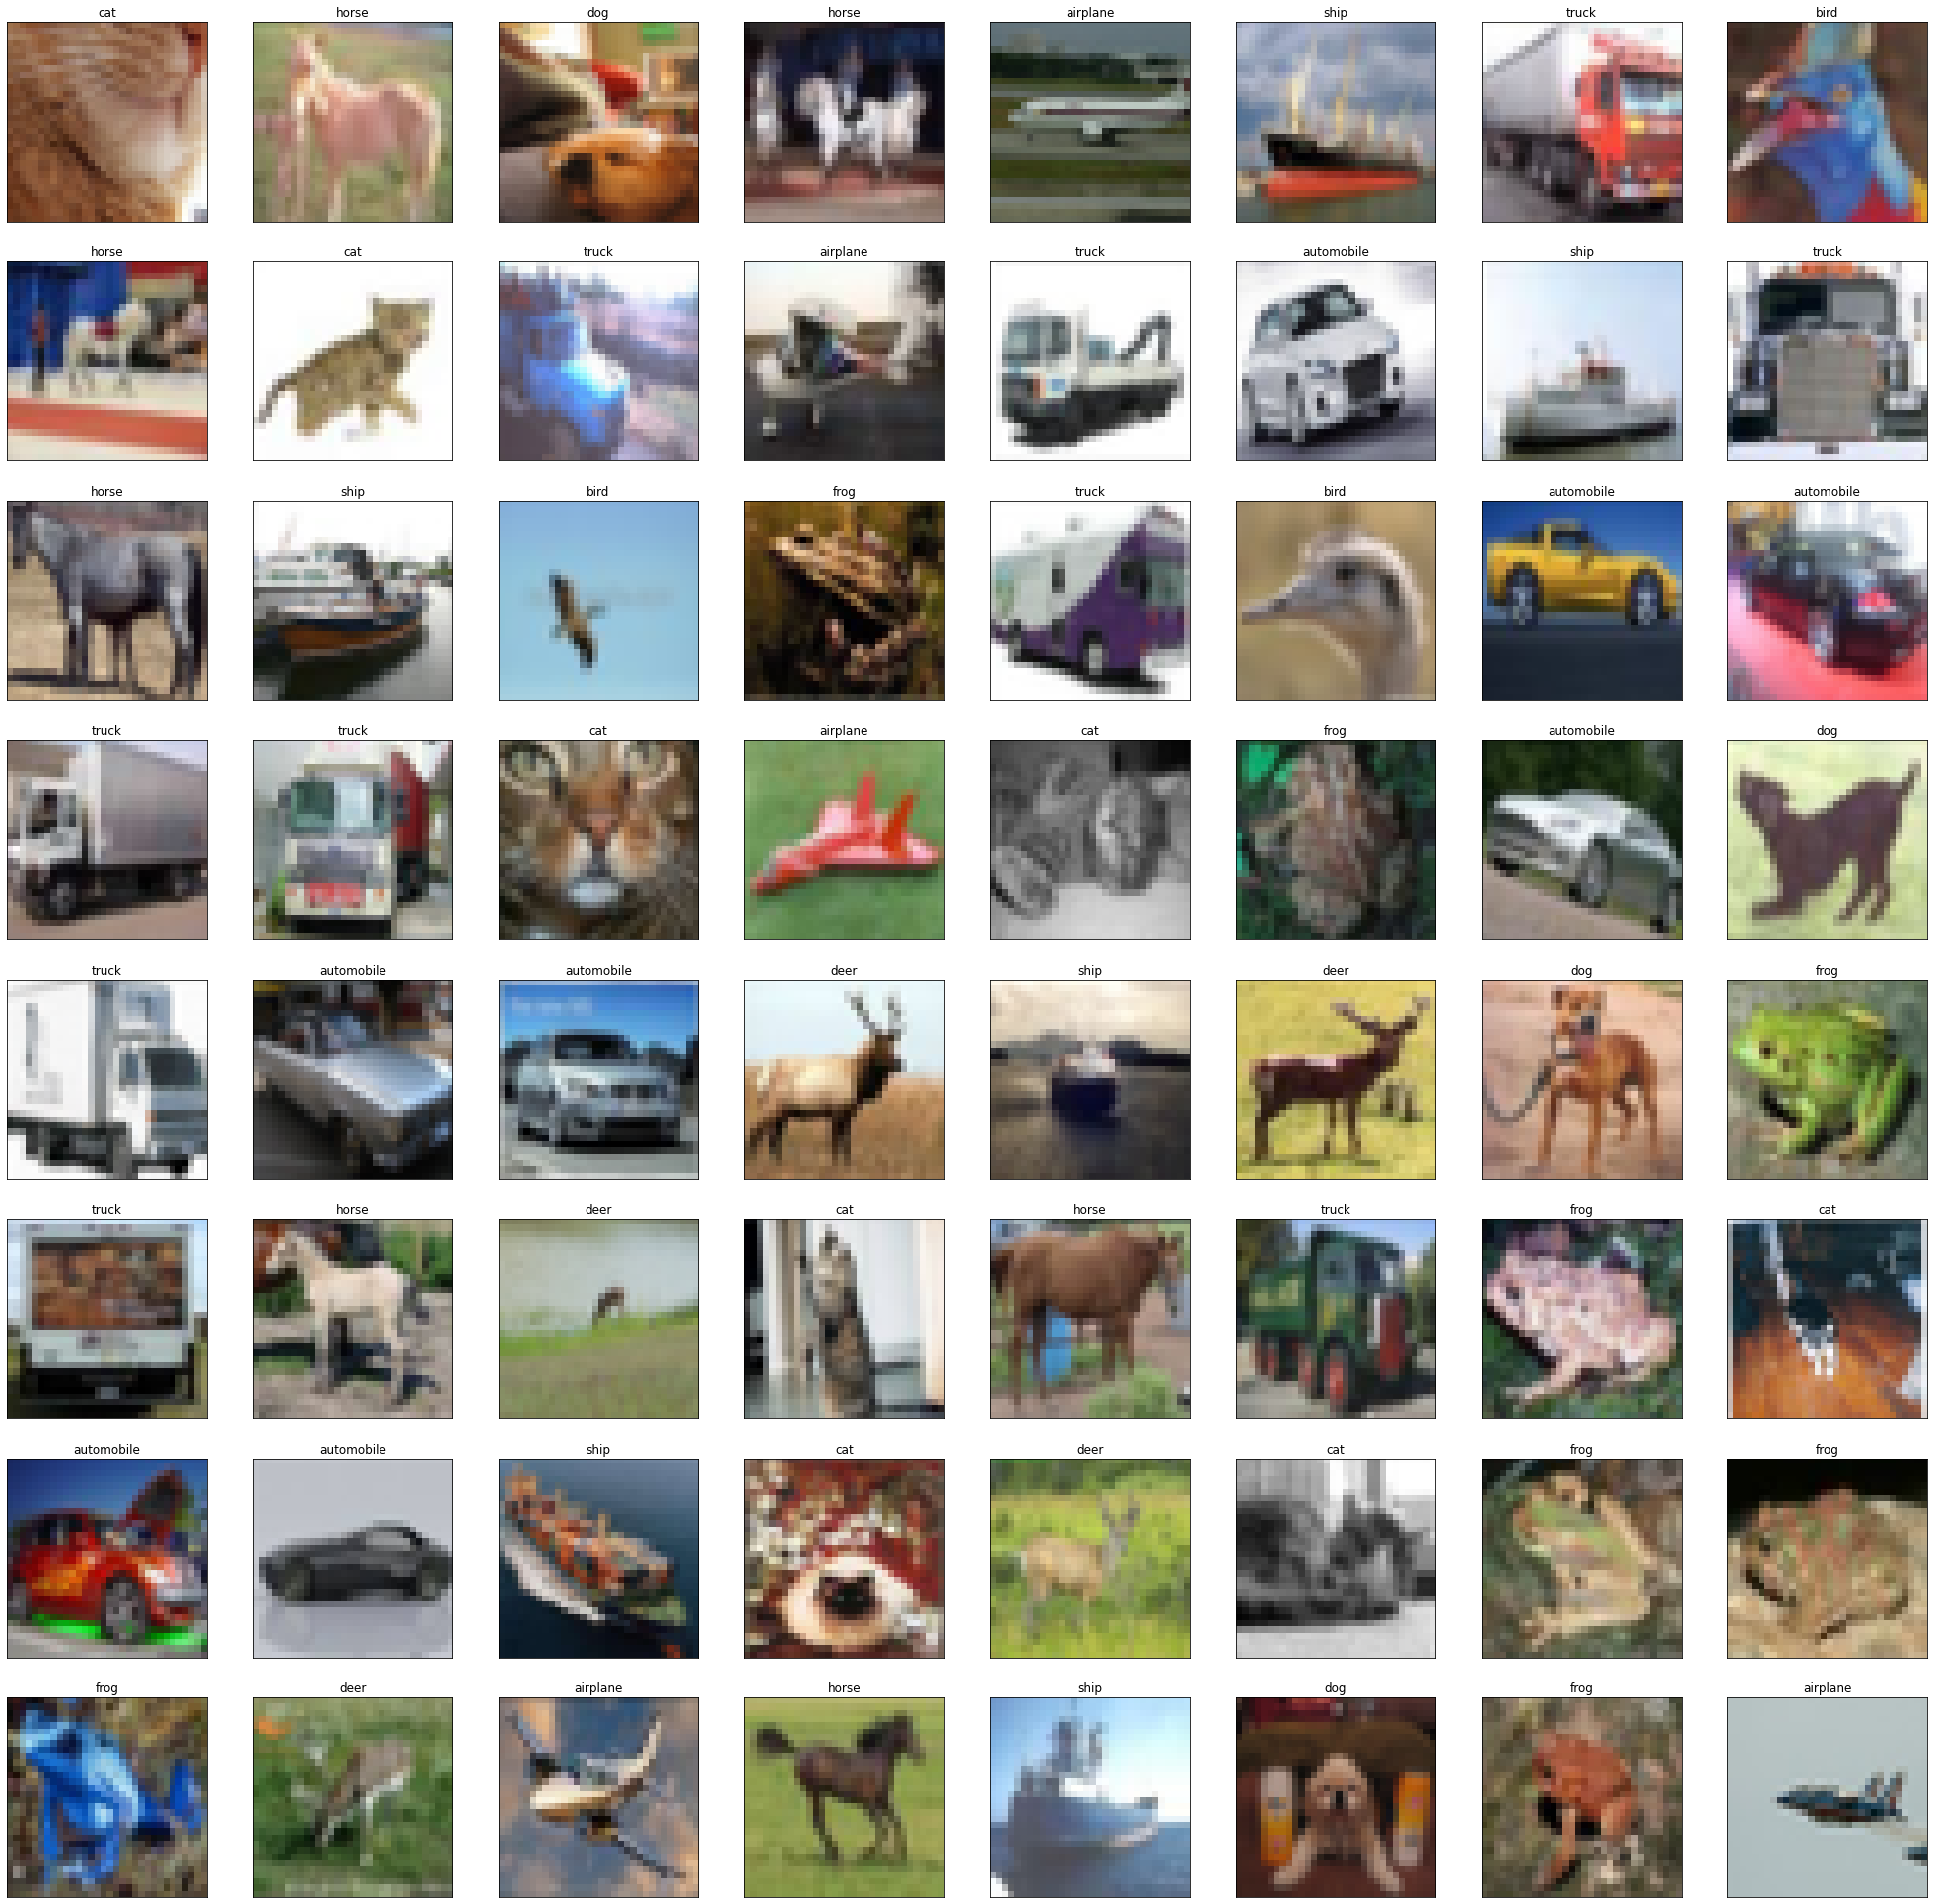

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(35,35))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(x_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

## Normalization

In [6]:
# Convert pixel values data type to float32
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_valid = x_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(x_train)
std  = np.std(x_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean) /(std+1e-7)
x_valid = (x_valid-mean)/(std+1e-7)

## Label Encodding

In [7]:
y_train

array([[3],
       [7],
       [5],
       ...,
       [5],
       [4],
       [8]], dtype=uint8)

In [8]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## Augmentation

In [10]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

## Model Config

In [11]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=x_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

2024-11-13 07:58:16.559092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 07:58:16.747798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

## Model Train

In [13]:
batch_size = 64

epochs = 100

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

model.fit(data_generator.flow(x_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(x_valid, y_valid),
          callbacks=[reduce_lr], 
          verbose=2)

Epoch 1/100


2024-11-13 07:58:22.465621: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2024-11-13 07:58:22.701201: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


625/625 - 105s - loss: 2.4302 - accuracy: 0.3231 - val_loss: 1.7824 - val_accuracy: 0.4293 - lr: 5.0000e-04 - 105s/epoch - 168ms/step
Epoch 2/100
625/625 - 103s - loss: 1.7791 - accuracy: 0.4429 - val_loss: 1.5704 - val_accuracy: 0.5017 - lr: 5.0000e-04 - 103s/epoch - 164ms/step
Epoch 3/100
625/625 - 104s - loss: 1.5545 - accuracy: 0.5119 - val_loss: 1.3805 - val_accuracy: 0.5672 - lr: 5.0000e-04 - 104s/epoch - 166ms/step
Epoch 4/100
625/625 - 103s - loss: 1.4107 - accuracy: 0.5543 - val_loss: 1.3066 - val_accuracy: 0.5812 - lr: 5.0000e-04 - 103s/epoch - 165ms/step
Epoch 5/100
625/625 - 101s - loss: 1.2669 - accuracy: 0.5941 - val_loss: 1.2027 - val_accuracy: 0.6205 - lr: 5.0000e-04 - 101s/epoch - 162ms/step
Epoch 6/100
625/625 - 106s - loss: 1.1755 - accuracy: 0.6299 - val_loss: 1.0720 - val_accuracy: 0.6709 - lr: 5.0000e-04 - 106s/epoch - 169ms/step
Epoch 7/100
625/625 - 105s - loss: 1.1001 - accuracy: 0.6524 - val_loss: 0.9386 - val_accuracy: 0.7094 - lr: 5.0000e-04 - 105s/epoch - 1

In [16]:
model.save('cifar_cnn.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('/home/cdsw/Belajar_Najmi/ANN/Final_Ex/cifar_cnn.h5')

## Result with Visual

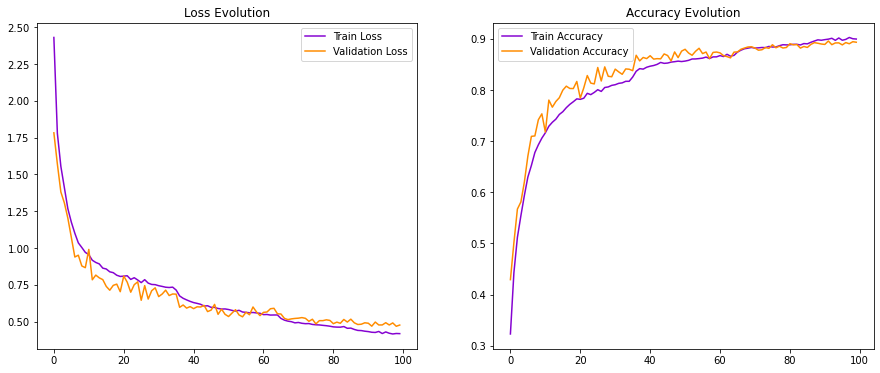

In [14]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

## Run Model with Test Set

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 3s 5ms/step - loss: 0.4814 - accuracy: 0.8887

Test Accuracy: 0.888700008392334
Test Loss:     0.4813818335533142


In [34]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

In [80]:
y_pred = model.predict(x_test)

313/313 [==============================] - 2s 7ms/step


In [81]:
y_pred = y_pred.argmax(axis=1)
y_pred

array([3, 8, 8, ..., 5, 1, 7])

In [27]:
# y_pred  = to_categorical(y_pred, 10)

In [82]:
# y_pred

In [84]:
y_test = y_test.argmax(axis=1)
y_test

array([3, 8, 8, ..., 5, 1, 7])

In [85]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1000
           1       0.94      0.96      0.95      1000
           2       0.87      0.85      0.86      1000
           3       0.83      0.72      0.77      1000
           4       0.88      0.89      0.88      1000
           5       0.90      0.78      0.83      1000
           6       0.79      0.97      0.87      1000
           7       0.93      0.94      0.93      1000
           8       0.95      0.93      0.94      1000
           9       0.88      0.96      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



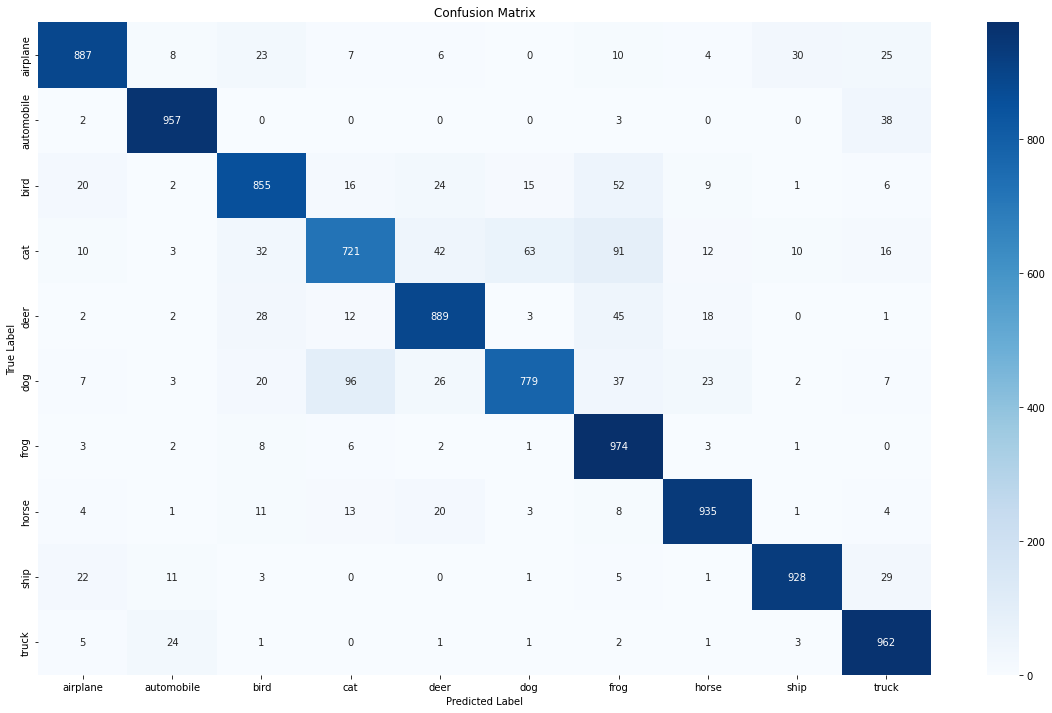

In [91]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Sampling New data with Model

### Sampling 1

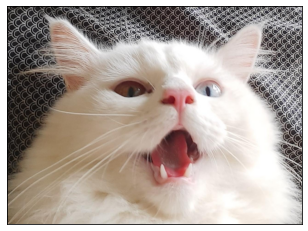

In [51]:
import cv2

path_image = "/home/cdsw/Belajar_Najmi/ANN/Final_Ex/MyAretha.jpg"
image = cv2.imread(path_image, cv2.IMREAD_UNCHANGED)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [52]:
image = cv2.resize(image, (32,32))
image = (image-mean)/(std+1e-7)
image = image.reshape((1, 32, 32, 3))

In [53]:
prediction = model.predict(image)

1/1 [==============================] - 0s 50ms/step


In [67]:
predicted_class = prediction.argmax()
print('Predict Label = ', class_names[predicted_class])

Predict Label =  cat


### Sampling 2

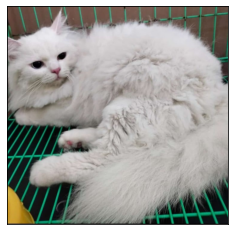

In [56]:
path_image = "/home/cdsw/Belajar_Najmi/ANN/Final_Ex/MyAretha2.jpg"
image = cv2.imread(path_image, cv2.IMREAD_UNCHANGED)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [57]:
image = cv2.resize(image, (32,32))
image = (image-mean)/(std+1e-7)
image = image.reshape((1, 32, 32, 3))

In [58]:
prediction = model.predict(image)

1/1 [==============================] - 0s 55ms/step


In [59]:
predicted_class = prediction.argmax()
print('Predict Label = ', class_names[predicted_class])

Predict Label =  frog


### Sampling 3

In [74]:
path_image = "https://cdn1-production-images-kly.akamaized.net/95RPSsDlQi8V7je3r8ao5sA55jw=/1200x1200/smart/filters:quality(75):strip_icc():format(webp)/kly-media-production/medias/4659406/original/099113300_1700695376-kucing_persia_01.jpg"

resp = urllib.request.urlopen(path_image)
image = np.asarray(bytearray(resp.read()), dtype="uint8")

image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

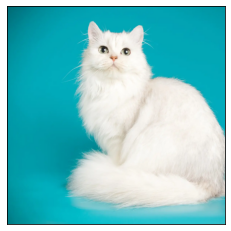

In [75]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [76]:
image = cv2.resize(image, (32,32))
image = (image-mean)/(std+1e-7)
image = image.reshape((1, 32, 32, 3))

In [77]:
prediction = model.predict(image)

1/1 [==============================] - 0s 82ms/step


In [78]:
predicted_class = prediction.argmax()
print('Predict Label = ', class_names[predicted_class])

Predict Label =  cat
